Map the "realm of acceptability" for a given HP mechanism (where in the par space is the mechanism effectively "off")

"Off"/"Accepting" is defined by the velocity vector of the parameters, averaged over all timesteps of the time sample, not exceeding .05 (for now)
Could later be defined by $\rho$'s always being zero (activations always within target range), but this might be a little restrictive for a CTRNN

Note that this "realm of acceptability" does not necessarily capture all the ways the HP mechanism can be successful because it is frozen in the time dimension (ignores HP-driven solutions)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cbook as cbook
from matplotlib import cm
import math
import sobol
import random

In [3]:
from pyloricfitness import *
from CTRNNclass import *
from HPevolution import *
from acceptance import *
from CTRNNgenomesamp import *

Defining and visualizing specific pyloric solution on which to operate

In [4]:
#a pyloric-like neurongenome evolved from the other notebook

sol1 = np.array([ 14.82024187,  10.61253584,-12.15141158,  -4.61967513,-15.81543225,  15.62745189,  14.71262429,   2.0523492 , 1.86045721, -10.25813196,  -0.29218389,  -2.47607644, 1.13091869,   4.00518322,   3.57617411])

solcoevolved = np.array([-1.66277628e+00,  6.08372573e+00,  2.02550211e-02,  9.42733663e-01,
        8.46697321e+00,  4.99193437e+00, -5.60691553e+00, -6.66479592e+00,
        5.06919151e+00,  3.36623523e+00, -3.18997036e+00, -4.84189892e+00,
        7.37470557e+00,  9.79376709e+00,  2.56164698e+00])

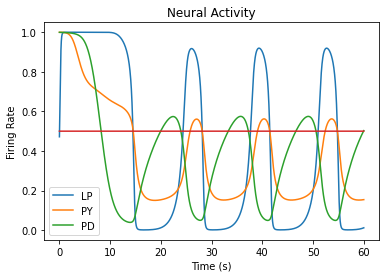

In [5]:
#visualize that genome with any HP you want
duration = 60 #plot duration
useHP = 0

HPexample = np.array([6.45682782e-02 ,4.69660585e-02, 7.99857040e-02, 8.78069405e-01, 8.64082556e-01, 9.21333979e-01, 4.20627851e+01, 1.84534807e+01, 1.36000000e+02])
HPC = CTRNN(3,dt,duration,np.copy(HPexample),np.copy(sol1))
HPC.initializeState(initial_states[0])
HPC.resetStepcount()

for i in range(len(HPC.time)):        #run the CTRNN for the allotted duration
    HPC.ctrnnstep(useHP)
HPC.plot()
#HPC.plotparams()

In [5]:
print(acceptance(np.array([0,0,0,.99,.99,.99,20.,40.,1]),sol1))
#print(acceptance(HPexample,sol1))

pyloriclike(sol1)

1


0.6335158467340178

Evolving on the HP mechanisms to minimize type I and type II error:

    Fitness function is 
    (# pts where pyloric & accepted) + (# pts non-pyloric & not accepted) / 
    (#pts pyloric & not accepted) + (#pts non-pyloric & accepted) 

In [6]:
neurongenomesamp = np.loadtxt('neurongenomesample.csv')

In [7]:
#precalculated pyloric fitness of each circuit in the sample
pyloricfitnessofsample = np.loadtxt('pyloricfitnessofsample.csv')

pyloricones = neurongenomesamp[pyloricfitnessofsample>=.3]
nonpyloricones = neurongenomesamp[pyloricfitnessofsample<.3]
pyloriccount = len(pyloricones)
nonpyloriccount = len(nonpyloricones)

print('# pyloric ones:',pyloriccount)

# pyloric ones: 31


In [12]:
weighting = [2,1] #ratio of how much to weight [correct acceptances, correct rejections] -- integers

def HPfitness(HPgenome): #changed to differentially weight correct acceptance and correct rejection based on number of points of each
    '''max fitness is 1. half for correctly accepting all pyloric and half for correctly rejecting non-pyloric'''
    correct_accept = 0    #correctly accepted points
    correct_reject = 0    #correctly rejected points
    idx = 0
    while idx in range(len(neurongenomesamp)): #"sample" defined outside function so it stays the same throughout evolution
        pyloricfitness = pyloricfitnessofsample[idx] #precalculated for the quasi-random sample of CTRNNs
        accept = acceptance(HPgenome,neurongenomesamp[idx])
        if (pyloricfitness >= .3):
            if accept:
                correct_accept += 1   #accepts a pyloric
        else:
            if not accept:
                correct_reject += 1   #rejects a non-pyloric
        idx += 1
    fitness = (((correct_accept/pyloriccount)*weighting[0]) + ((correct_reject/nonpyloriccount)*weighting[1]))/(sum(weighting))
    return (fitness)


In [9]:
myHPgenome = np.array([.25,.25,.25,.75,.75,.75,40,20,750])

HPfitness(myHPgenome)

0.34738290116239084

In [13]:
def randomHPsample(CTRNNsize, samplesize):
    genomes = np.zeros((samplesize,(CTRNNsize*2) + 3))
    for i in range(samplesize):
        #first, set random bias time constant, weight time constant, and sliding window length
        HPgenome = np.array([1,1,1,0,0,0,np.clip(np.random.normal(loc=40,scale=10),10,70),np.clip(np.random.normal(loc=20,scale=5),10,30),np.random.randint(1,high=100)])
        for j in range(CTRNNsize): #for every neuron, set a lower and upper bound
            while HPgenome[j] > .5:
                HPgenome[j] = 1-np.random.power(1)
            while HPgenome[j+CTRNNsize] < .5:
                HPgenome[j+CTRNNsize] = 1-np.random.power(1)
        genomes[i] = HPgenome
    return genomes

In [14]:
popsize = 5
HPsample = randomHPsample(3,popsize)

recombProb = .5
mutatProb = .25
generations = 15
differentialapp = [1,1,1]


M = Microbial(HPfitness,HPsample,recombProb, mutatProb, generations,differentialapp)

M.run()

0
0.3333333333333333


KeyboardInterrupt: 

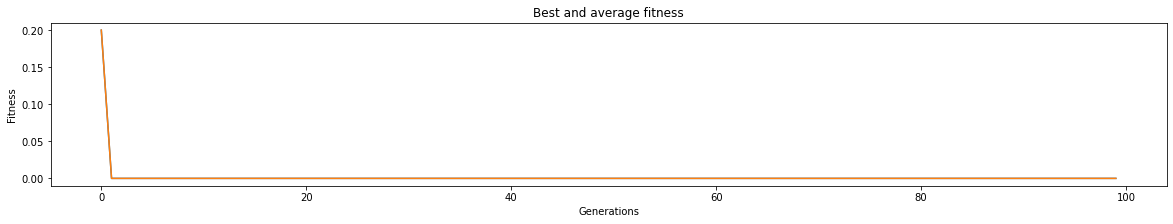

[ 0.12212237  0.06207582  0.24029146  0.8779114   0.67468318  0.66912811
 45.76591316 17.10101235 21.        ]


0

In [17]:
M.showFitness()
bestind = M.fitStats()[-1]
print(bestind)

acceptance(bestind,neurongenomesamp[100])

Alternative to evolution: 
1) randomly generate genomes until it correctly classifies one pyloric and one nonpyloric rhythm

2) add another point, mutating until it is correctly classified without losing the others

3) repeat

Evolution when HP only applied to the PD neuron (N3)

Hypothesizing that I'll get some HP-driven oscillations which will make N3 like a pacemaker
AAAAnnd that's wrong because i classify that as rejection


In [ ]:
popsize = 15
HPsample = randomHPsample(popsize)

for i in range(popsize):
    HPsample[i] = differentialapplication(HPsample[i],[0,0,1])

recombProb = .5
mutatProb = .25
generations = 50

M = Microbial(HPfitness,HPsample,recombProb, mutatProb, generations,[0,0,1])

M.run()
M.showFitness()

0
0.3333333333333333


Visualising overlap of the realm of acceptance and the pyloric fitness

In [9]:
dim1lb = 6
dim1ub = 16
dim2lb = 6
dim2ub = 16
spacing = .5 #(must go evenly into both the interval widths)

dim1 = 0 #index of par on x axis
dim2 = 1 #index par on y axis

acceptancegrid = np.zeros((int((dim1ub-dim1lb)/spacing),int((dim2ub-dim2lb)/spacing)))
fitnessgrid = np.zeros((int((dim1ub-dim1lb)/spacing),int((dim2ub-dim2lb)/spacing)))    #pyloric fitness without HP

HPgenomegeneric = np.array([.25,.25,.25,.75,.75,.75,40,20,1])

HPgenomecoevolved = np.array([ 0.35847261 , 0.20945884 , 0.34201794 , 0.36847261 , 0.21945883,  0.82836489,
 39.9910632 , 19.0137781,  40.])

calcfitnessfirsttime = 1

neurongenome = np.copy(sol1)
neurongenome[dim1] = dim1lb  

#evenly spaced grid of points
for i in range(int((dim1ub-dim1lb)/spacing)):
    neurongenome[dim2] = dim2lb 
    for j in range(int((dim2ub-dim2lb)/spacing)):
        acceptancegrid[i,j] = acceptance(HPgenomegeneric, neurongenome)
        if calcfitnessfirsttime: #if you're going through this loop for the first time, need to calculate fitness at every pt
            fitnessgrid[i,j] = pyloriclike(neurongenome)
        neurongenome[dim2] += spacing       #and increment it with each loop
    neurongenome[dim1] += spacing           

KeyboardInterrupt: 

NameError: name 'acceptancegridsol1_2' is not defined

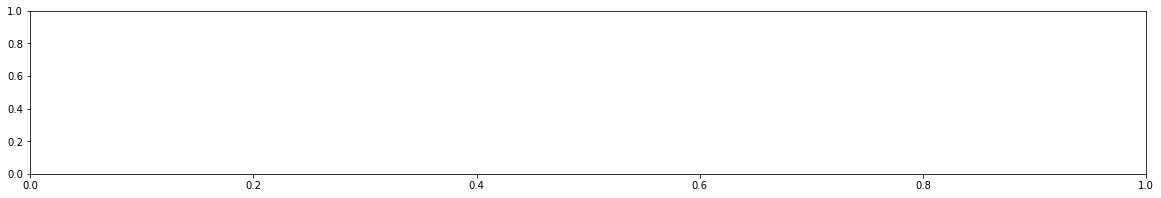

In [16]:
cmap = cm.RdBu

fig, ax2 = plt.subplots(ncols=1)

norm = colors.BoundaryNorm((0,.5,1), ncolors=cmap.N, clip=True)

pc = ax2.pcolormesh(acceptancegrid, norm=norm, cmap=cmap)
fig.colorbar(pc, ax=ax2)
fig.set_figheight(10)
fig.set_figwidth(17)
ax2.set_title(r'$w_{12}$ vs $w_{11}$ between [6,16] and [6,16]')
ax2.set_ylabel(r'$w_{11}$')
ax2.set_xlabel(r'$w_{12}$')
xticks = np.arange(0,(int((dim2ub-dim2lb)/spacing))+1)
ax2.set_xticks(xticks)
xticklabels = np.round(np.arange(dim2lb,dim2ub+0.0001,spacing),3)
ax2.set_xticklabels(xticklabels,rotation = 90)
ax2.tick_params(axis='both', which='major', labelsize=7)
yticks = np.arange(0,(int((dim1ub-dim1lb)/spacing))+1)
ax2.set_yticks(yticks)
yticklabels = np.round(np.arange(dim1lb,dim1ub+0.0001,spacing),3)
ax2.set_yticklabels(yticklabels)

plt.show()